# **1) Initiall instructions**

In [ ]:
!pip install rdkit
!pip install xgboost
!pip install catboost
!pip install optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
from joblib import dump
import optuna
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem.AllChem import GetMorganGenerator

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import matthews_corrcoef
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# **1) Ki dataset**

In [ ]:
data_Ki = pd.read_csv('/content/drive/MyDrive/5ht7/5ht7_Ki.csv', sep=';')
list_of_cols = ["Molecule ChEMBL ID", "Smiles", "Standard Type", "Standard Relation", "Standard Value", "Standard Units", "Action Type", "Document ChEMBL ID"]
df_Ki = pd.DataFrame(data_Ki, columns = list_of_cols)
df_Ki = df_Ki[df_Ki['Action Type'].isin(['ANTAGONIST', 'INHIBITOR'])]

In [ ]:
df_Ki.isna().sum()

,0
Molecule ChEMBL ID,0
Smiles,0
Standard Type,0
Standard Relation,0
Standard Value,0
Standard Units,0
Action Type,0
Document ChEMBL ID,0


# **2) IC50 dataset**

According to Kaliokoski et al. in  ["Comparability of Mixed IC50 Data – A Statistical Analysis"](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0061007), Ki value is approximately equal to IC50/2.

In [ ]:
data_IC50 = pd.read_csv('/content/drive/MyDrive/5ht7/5ht7_IC50.csv', sep=';')
df_IC50 = pd.DataFrame(data_IC50, columns = list_of_cols)
df_IC50 = df_IC50[df_IC50['Action Type'].isin(['ANTAGONIST', "INHIBITOR"])]

In [ ]:
df_IC50['Standard Type'] = 'Ki'
df_IC50['Standard Value'] = df_IC50['Standard Value'] * 0.5

In [ ]:
df_IC50.isna().sum()

,0
Molecule ChEMBL ID,0
Smiles,0
Standard Type,0
Standard Relation,0
Standard Value,0
Standard Units,0
Action Type,0
Document ChEMBL ID,0


# **3) Concatenation**

In [ ]:
df_concat = pd.concat([df_Ki, df_IC50])
print(f'df_concat shape before drop_duplicates(): {df_concat.shape}')
df_concat = df_concat.drop_duplicates(subset=['Molecule ChEMBL ID'])
print(f'df_concat shape after drop_duplicates(): {df_concat.shape}')

df_concat shape before drop_duplicates(): (257, 8)
df_concat shape after drop_duplicates(): (177, 8)


In [ ]:
df_concat['Bin_Activity'] = np.where(df_concat['Standard Value'] <= 50, 1, 0) #1 means 'active'; 0 means 'not active'
df_final = df_concat
df_final.reset_index(drop=True, inplace=True)
df_final.shape

(177, 9)

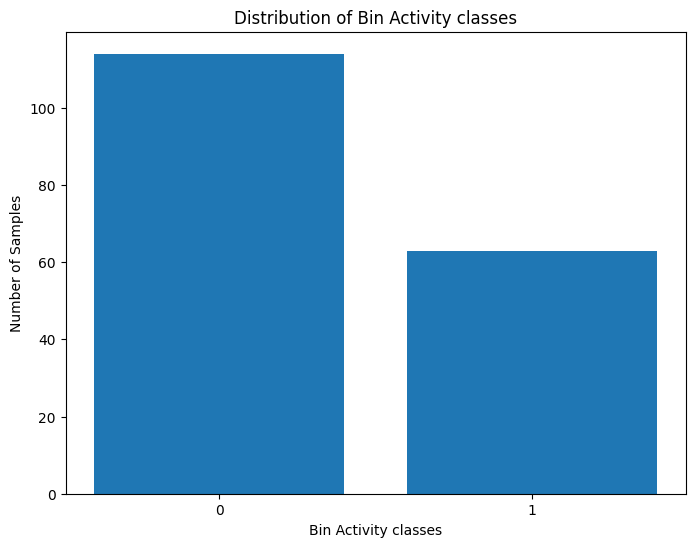

In [ ]:
activity_counts = df_final['Bin_Activity'].value_counts()
colors = ['green', 'orange']

plt.figure(figsize=(8, 6))
plt.bar(activity_counts.index, activity_counts.values, color=colors)
plt.xlabel('Bin Activity classes')
plt.ylabel('Number of Samples')
plt.title('Distribution of Bin Activity classes')
plt.xticks(activity_counts.index)
plt.gca().set_facecolor('#f0f0f0')
plt.grid()
plt.show()

# **4) Radius, fingeprints length and model screening**

In [ ]:
%%time
list_of_models = [
    RandomForestClassifier(random_state=13),
    SVC(random_state=13),
    LogisticRegression(random_state=13),
    XGBClassifier(random_state=13),
    CatBoostClassifier(random_state=13, verbose=False),
]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

fps_list = [1024, 2048, 4096, 8192]
rds_list = [1, 2, 3, 4, 5]

results = []

for fps in fps_list:
    for rds in rds_list:
        morgan_gen = GetMorganGenerator(radius=rds, fpSize=fps)
        df_final['Morgan_fps'] = df_final['Smiles'].apply(lambda x: morgan_gen.GetFingerprint(Chem.MolFromSmiles(x)))

        y = np.array(df_final['Bin_Activity'])
        X = np.array([np.array(x) for x in df_final['Morgan_fps']])

        for model in list_of_models:
            model_name = type(model).__name__
            model.fit(X, y)

            accuracy = cross_val_score(model, X, y, cv=skf, scoring='accuracy').mean()
            mcc = matthews_corrcoef(y, model.predict(X))

            results.append({
                "fps": fps,
                "rds": rds,
                "model": model_name,
                "accuracy": accuracy,
                "mcc": mcc
            })


CPU times: user 17min 13s, sys: 1min 17s, total: 18min 31s
Wall time: 13min 21s


In [ ]:
results_df = pd.DataFrame(results)

for model_name in results_df['model'].unique():
    print(f"Model: {model_name}")
    model_results = results_df[results_df['model'] == model_name].sort_values(by='accuracy', ascending=False)

    for _, row in model_results.iterrows():
        print(f"fps: {row['fps']}, rds: {row['rds']} ==> Accuracy: {row['accuracy']*100:.2f}% ; Matthews correlation coefficient: {row['mcc']:.2f}")
    print("=================================================")


Model: RandomForestClassifier
fps: 1024, rds: 1 ==> Accuracy: 87.05% ; Matthews correlation coefficient: 0.98
fps: 2048, rds: 1 ==> Accuracy: 85.92% ; Matthews correlation coefficient: 0.98
fps: 2048, rds: 2 ==> Accuracy: 85.89% ; Matthews correlation coefficient: 0.98
fps: 8192, rds: 1 ==> Accuracy: 85.35% ; Matthews correlation coefficient: 0.98
fps: 1024, rds: 2 ==> Accuracy: 85.33% ; Matthews correlation coefficient: 0.98
fps: 2048, rds: 4 ==> Accuracy: 84.78% ; Matthews correlation coefficient: 0.98
fps: 8192, rds: 3 ==> Accuracy: 84.78% ; Matthews correlation coefficient: 0.98
fps: 4096, rds: 1 ==> Accuracy: 84.78% ; Matthews correlation coefficient: 0.98
fps: 8192, rds: 2 ==> Accuracy: 84.76% ; Matthews correlation coefficient: 0.98
fps: 2048, rds: 3 ==> Accuracy: 84.24% ; Matthews correlation coefficient: 0.98
fps: 1024, rds: 5 ==> Accuracy: 84.22% ; Matthews correlation coefficient: 0.98
fps: 4096, rds: 4 ==> Accuracy: 84.22% ; Matthews correlation coefficient: 0.98
fps: 4096,

# **5) Models optimization**

## **5.1) RandomForrestClassifier**

In [ ]:
morgan_gen = GetMorganGenerator(radius=1, fpSize=1024)
df_final['Morgan_fp'] = df_final['Smiles'].apply(lambda x: morgan_gen.GetFingerprint(Chem.MolFromSmiles(x)))

y = np.array(df_final['Bin_Activity'])
X = np.array([np.array(x) for x in df_final['Morgan_fp']])

In [ ]:
def objective(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 1000)
  max_depth = trial.suggest_int('max_depth', 3, 50)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])


  model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, criterion=criterion, random_state=13,)
  score = cross_val_score(model, X, y, cv=skf, scoring='accuracy').mean()

  return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

[I 2024-12-14 14:34:37,597] A new study created in memory with name: no-name-efe7a59b-ff38-4a5d-851d-572f9126f62f
[I 2024-12-14 14:34:39,143] Trial 0 finished with value: 0.7463492063492063 and parameters: {'n_estimators': 212, 'max_depth': 41, 'min_samples_split': 6, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 0 with value: 0.7463492063492063.
[I 2024-12-14 14:34:45,291] Trial 1 finished with value: 0.8082539682539682 and parameters: {'n_estimators': 731, 'max_depth': 40, 'min_samples_split': 8, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8082539682539682.
[I 2024-12-14 14:34:47,392] Trial 2 finished with value: 0.7687301587301587 and parameters: {'n_estimators': 216, 'max_depth': 41, 'min_samples_split': 3, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 1 with value: 0.8082539682539682.
[I 2024-12-14 14:34:52,686] Trial 3 finished with value: 0.7238095238095238 and parameters: {'n_estimators': 814, 'max_depth': 8, 'min_samp

In [ ]:
best_params_rfc = study.best_params

n_estimators = best_params_rfc['n_estimators']
max_depth = best_params_rfc['max_depth']
min_samples_split = best_params_rfc['min_samples_split']
min_samples_leaf = best_params_rfc['min_samples_leaf']
criterion = best_params_rfc['criterion']

In [ ]:
best_model_rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, criterion=criterion, random_state=13)
best_model_rfc_acc = []
best_model_rfc_mcc = []

best_model_rfc.fit(X, y)
score = cross_val_score(best_model_rfc, X, y, cv=skf, scoring='accuracy').mean()
best_model_rfc_acc.append(score)
best_model_rfc_mcc.append(matthews_corrcoef(y, best_model_rfc.predict(X)))

print(f'Accuracy for Random Forest Classifier (after Optuna optimization): {best_model_rfc_acc[0]*100:.2f} %')
print(f'MCC for Random Forest Classifier (after Optuna optimization): {best_model_rfc_mcc[0]:.2f}')

Accuracy for Random Forest Classifier (after Optuna optimization): 87.62 %
MCC for Random Forest Classifier (after Optuna optimization): 0.98


## **5.2) XGBoost**

In [ ]:
morgan_gen = GetMorganGenerator(radius=1, fpSize=8192)
df_final['Morgan_fp'] = df_final['Smiles'].apply(lambda x: morgan_gen.GetFingerprint(Chem.MolFromSmiles(x)))

y = np.array(df_final['Bin_Activity'])
X = np.array([np.array(x) for x in df_final['Morgan_fp']])

In [ ]:
def objective(trial):
  eta = trial.suggest_float('eta', 0.01, 1)
  n_estimators = trial.suggest_int('n_estimators', 100, 1000)
  min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
  gamma = trial.suggest_int('gamma', 0, 10)
  subsample = trial.suggest_float('subsample', 0.5, 1)
  max_depth = trial.suggest_int('max_depth', 3, 50)
  colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1)
  reg_alpha = trial.suggest_int('reg_alpha', 0, 10)
  reg_lambda = trial.suggest_int('reg_lambda', 0, 10)

  model = XGBClassifier(min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, max_depth=max_depth, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=13)
  score = cross_val_score(model, X, y, cv=skf, scoring='accuracy').mean()

  return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

[I 2024-12-14 14:48:02,256] A new study created in memory with name: no-name-2f30f8a8-13f7-48e2-b1d6-ee8614f0df32
[I 2024-12-14 14:48:05,352] Trial 0 finished with value: 0.7066666666666667 and parameters: {'eta': 0.8716431008128589, 'n_estimators': 346, 'min_child_weight': 10, 'gamma': 2, 'subsample': 0.8825467817276746, 'max_depth': 47, 'colsample_bytree': 0.9746153596290892, 'reg_alpha': 3, 'reg_lambda': 5}. Best is trial 0 with value: 0.7066666666666667.
[I 2024-12-14 14:48:06,948] Trial 1 finished with value: 0.6441269841269841 and parameters: {'eta': 0.9623882096518032, 'n_estimators': 339, 'min_child_weight': 5, 'gamma': 6, 'subsample': 0.6314332985873683, 'max_depth': 31, 'colsample_bytree': 0.7699885321942979, 'reg_alpha': 7, 'reg_lambda': 9}. Best is trial 0 with value: 0.7066666666666667.
[I 2024-12-14 14:48:08,591] Trial 2 finished with value: 0.6441269841269841 and parameters: {'eta': 0.4884842312382075, 'n_estimators': 694, 'min_child_weight': 5, 'gamma': 3, 'subsample': 

In [ ]:
best_params_xgb = study.best_params

eta = best_params_xgb['eta']
n_estimators = best_params_xgb['n_estimators']
min_child_weight = best_params_xgb['min_child_weight']
gamma = best_params_xgb['gamma']
subsample = best_params_xgb['subsample']
max_depth = best_params_xgb['max_depth']
colsample_bytree = best_params_xgb['colsample_bytree']
reg_alpha = best_params_xgb['reg_alpha']
reg_lambda = best_params_xgb['reg_lambda']


In [ ]:
best_model_xgb = XGBClassifier(min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, max_depth=max_depth, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=13)
best_model_xgb_acc = []
best_model_xgb_mcc = []

best_model_xgb.fit(X, y)
score = cross_val_score(best_model_xgb, X, y, cv=skf, scoring='accuracy').mean()
best_model_xgb_acc.append(score)
best_model_xgb_mcc.append(matthews_corrcoef(y, best_model_xgb.predict(X)))

print(f'Accuracy for XGBoost Classifier (after Optuna optimization): {best_model_xgb_acc[0]*100:.2f} %')
print(f'MCC for XGBoost Classifier (after Optuna optimization): {best_model_xgb_mcc[0]:.2f}')


Accuracy for XGBoost Classifier (after Optuna optimization): 85.35 %
MCC for XGBoost Classifier (after Optuna optimization): 0.79


# **6) Best model**

In [ ]:
os.chdir('/content/drive/MyDrive/5ht7')
!pwd
!ls -l

/content/drive/MyDrive/5ht7
total 3140
-rw------- 1 root root  272976 Dec 14 11:07 5ht7_IC50.csv
-rw------- 1 root root 2033758 Dec 14 11:06 5ht7_Ki.csv
-rw------- 1 root root  172421 Dec 14 14:54 5HT-7_ml_notebook.ipynb
-rw------- 1 root root  730233 Dec 14 13:22 best_rfc_model.joblib
drwx------ 4 root root    4096 Dec 14 14:34 catboost_info


In [ ]:
#Model save

final_model = best_model_rfc
path = os.path.join(os.getcwd(), 'best_rfc_model.joblib')
dump(final_model, path)

['/content/drive/MyDrive/5ht7/best_rfc_model.joblib']